In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# librerias
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

from pmdarima.arima import auto_arima
from pmdarima.arima import ARIMA

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
df= pd.read_csv("C:\\Users\\Flore\\THEBRIDGE\\2503_dsft_thebridge_FlorenciaGD\\3-Machine_Learning\\ML_Guide\\ML_Finance_Florencia\\dataset_limpio_indicePreciosConsumidor.csv", parse_dates = ['date'], index_col = 'date')
df

,freq,unit,coicop,geo,hicp
date,,,,,
2018-01-01,M,I15,CP00,AT,103.86
2018-01-01,M,I15,CP00,BE,103.82
2018-01-01,M,I15,CP00,BG,101.08
2018-01-01,M,I15,CP00,CY,96.47
2018-01-01,M,I15,CP00,CZ,104.40
...,...,...,...,...,...
2025-03-01,M,I15,CP07,PT,122.41
2025-03-01,M,I15,CP07,RO,137.07
2025-03-01,M,I15,CP07,SE,133.01


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24831 entries, 2018-01-01 to 2025-03-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   freq    24831 non-null  object 
 1   unit    24831 non-null  object 
 2   coicop  24831 non-null  object 
 3   geo     24831 non-null  object 
 4   hicp    24831 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.1+ MB


In [4]:
df.describe()

,hicp
count,24831.000000
mean,118.413369
std,20.706665
min,73.010000
25%,104.590000
50%,111.300000
75%,128.000000
max,233.820000


In [5]:
df["coicop"].unique()

array(['CP00', 'CP01', 'CP011', 'CP0111', 'CP01111', 'CP01112', 'CP02',
       'CP03', 'CP04', 'CP06', 'CP07'], dtype=object)

In [6]:
# Si no nos pilla bien la fecha
df['fecha_str'] = df.index.astype(str)

df[['year', 'month', 'day']] = df['fecha_str'].str.split('-', expand=True)
df['year'] = df['year'].astype(int)
df['month'] = df['month'].astype(int)
df['day'] = df['day'].astype(int)

df['new_date'] = pd.to_datetime(df[['year', 'month', 'day']])
df.head()

,freq,unit,coicop,geo,hicp,fecha_str,year,month,day,new_date
date,,,,,,,,,,
2018-01-01,M,I15,CP00,AT,103.86,2018-01-01,2018,1,1,2018-01-01
2018-01-01,M,I15,CP00,BE,103.82,2018-01-01,2018,1,1,2018-01-01
2018-01-01,M,I15,CP00,BG,101.08,2018-01-01,2018,1,1,2018-01-01
2018-01-01,M,I15,CP00,CY,96.47,2018-01-01,2018,1,1,2018-01-01
2018-01-01,M,I15,CP00,CZ,104.40,2018-01-01,2018,1,1,2018-01-01


<Figure size 1500x700 with 0 Axes>

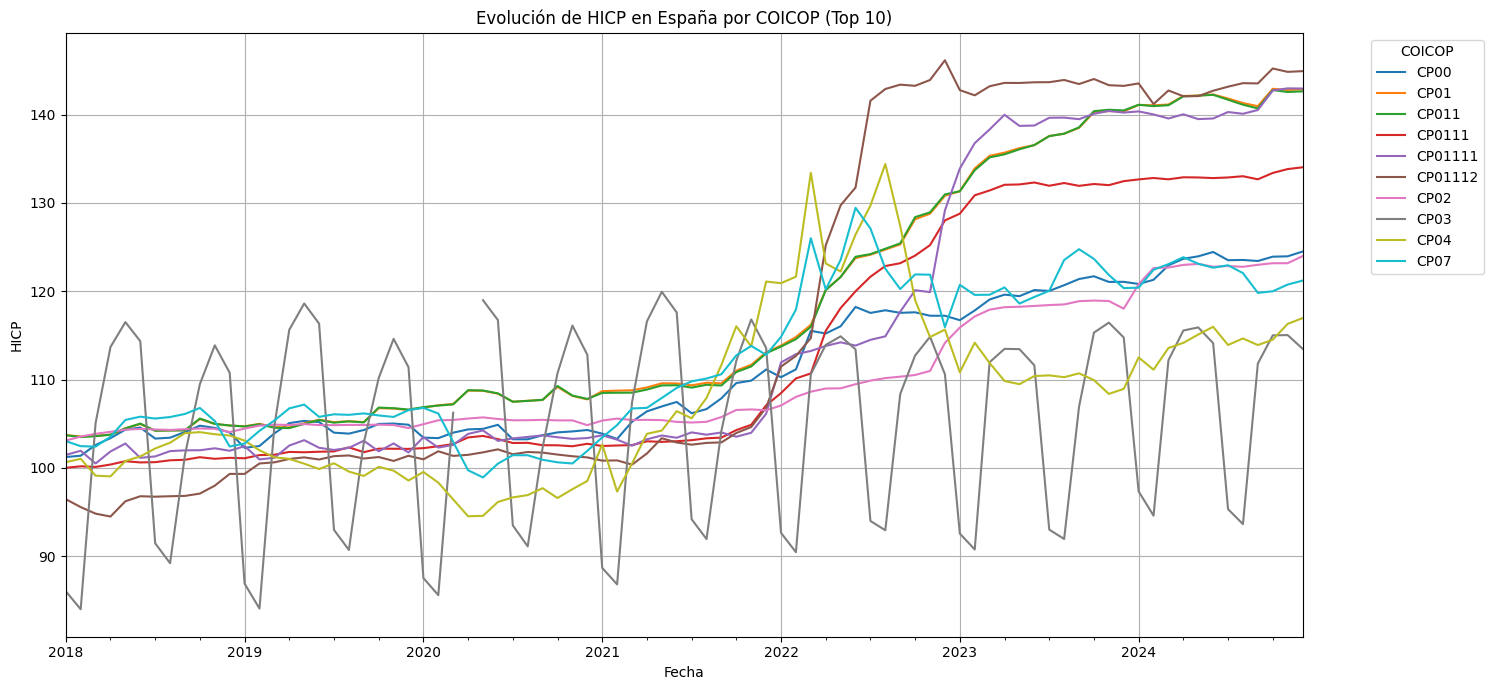

In [7]:
import matplotlib.pyplot as plt

# Filtrar solo España desde 2018 a 2024
df_es = df[(df['geo'] == 'ES') & (df['new_date'] >= '2018-01-01') & (df['new_date'] <= '2024-12-01')]

# Escoger los 10 COICOP más comunes o importantes (puedes personalizar esta lista)
top_coicops = df_es['coicop'].value_counts().head(10).index.tolist()
df_es_top = df_es[df_es['coicop'].isin(top_coicops)]

# Pivotar para graficar
pivot = df_es_top.pivot(index='new_date', columns='coicop', values='hicp')

# Graficar
plt.figure(figsize=(15,7))
pivot.plot(figsize=(15,7), colormap='tab10')
plt.title('Evolución de HICP en España por COICOP (Top 10)')
plt.xlabel('Fecha')
plt.ylabel('HICP')
plt.grid(True)
plt.legend(title='COICOP', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

- Tendencia al alza, aumento sostenido de precio desde mediados del 2021, lo cual refleja inflación
- Picos altos en 2022
- Subidas muy pronunciadas en líneas como CP01111 (Pan) y CP04 (vivenda, agua, electricidad, gas y otros combustibles). Coincide con el perçiodo post-pandemia y crisis energética.
- Estacionalidad con CP03 (ropa y calzado) muestra fuertes subidas y bajadas cada año por las rebajas de temporada.
- CP06 evolución más lineal. Los precios en el sector de la salud parece ser que varían menos


In [8]:
#Correlación con CP00 (Inflación general) para elegir las mejores features
df_pivot= df_es.pivot(index= "new_date", columns="coicop", values="hicp")

correlacion= df_pivot.corr()["CP00"].sort_values(ascending=False)

print(correlacion.head(11))

coicop
CP00       1.000000
CP01       0.978722
CP011      0.978591
CP0111     0.976194
CP01112    0.967758
CP06       0.955299
CP01111    0.948020
CP02       0.945912
CP07       0.933973
CP04       0.719864
CP03       0.238434
Name: CP00, dtype: float64


## CP00

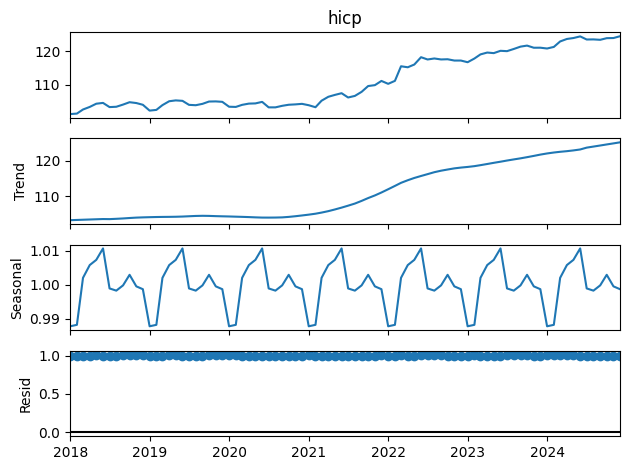

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Filtrar la serie
CP00 = df_es[df_es["coicop"] == "CP00"].copy()

# Descomposición
result_mul = seasonal_decompose(CP00['hicp'], model='multiplicative', extrapolate_trend='freq')

# Visualizar
result_mul.plot()
plt.tight_layout()
plt.show()

In [10]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstructed = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis = 1)
df_reconstructed.columns = ['seasonal', 
                            'trend', 'resid', 'actual_values']
df_reconstructed.tail()

,seasonal,trend,resid,actual_values
date,,,,
2024-08-01,0.998261,124.006575,0.997973,123.54
2024-09-01,0.999819,124.306328,0.993049,123.42
2024-10-01,1.002947,124.606080,0.991492,123.91
2024-11-01,0.999525,124.905832,0.992819,123.95
2024-12-01,0.998688,125.205585,0.995591,124.49


In [11]:
df_reconstructed['check_multiplicate'] = df_reconstructed['seasonal'] * df_reconstructed['trend'] * df_reconstructed['resid']
df_reconstructed

,seasonal,trend,resid,actual_values,check_multiplicate
date,,,,,
2018-01-01,0.987709,103.201152,0.993008,101.22,101.22
2018-02-01,0.988137,103.265750,0.993427,101.37,101.37
2018-03-01,1.002047,103.330348,0.990807,102.59,102.59
2018-04-01,1.005830,103.394946,0.993868,103.36,103.36
2018-05-01,1.007367,103.459544,1.000943,104.32,104.32
...,...,...,...,...,...
2024-08-01,0.998261,124.006575,0.997973,123.54,123.54
2024-09-01,0.999819,124.306328,0.993049,123.42,123.42
2024-10-01,1.002947,124.606080,0.991492,123.91,123.91


## CP01
(Alimentos y bebidas no alcohólicas)

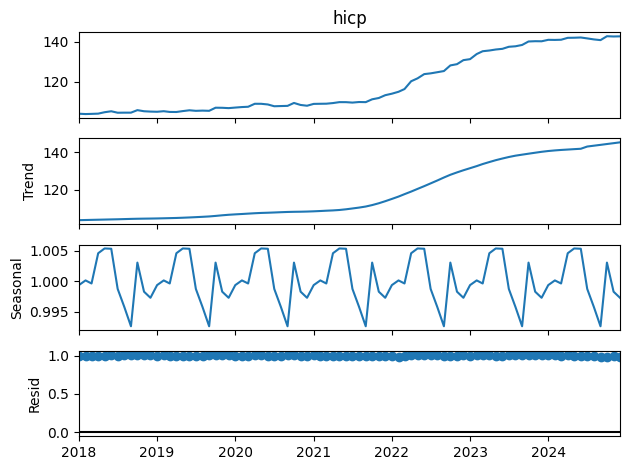

In [12]:
# Filtrar la serie
CP01 = df_es[df_es["coicop"] == "CP01"].copy()

# Descomposición
result_mul = seasonal_decompose(CP01['hicp'], model='multiplicative', extrapolate_trend='freq')

# Visualizar
result_mul.plot()
plt.tight_layout()
plt.show()

In [13]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstr_CP01 = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis = 1)
df_reconstr_CP01.columns = ['seasonal', 'trend', 'resid', 'actual_values']
df_reconstr_CP01.tail()

,seasonal,trend,resid,actual_values
date,,,,
2024-08-01,0.995747,143.396115,0.989661,141.31
2024-09-01,0.992569,143.842079,0.987230,140.95
2024-10-01,1.003051,144.288043,0.987506,142.92
2024-11-01,0.998264,144.734008,0.988284,142.79
2024-12-01,0.997259,145.179972,0.986725,142.86


Aquí descompongo el índice de precios de CP01 (Alimentos y bebidas no alcoholicas):

Trend: Suaviza los valores para mostrar la dirección general de precios sin el ruido ni la estacionalidad. Se ve como sube la inflación a lo largo de los años.

Estacionalidad: Patrones repetitivos precios que suben en verano y navidad
Ruido: Lo que queda después de eliminar tendencia y ruido (variaciones impredecibles). No hay anomalías.


## CP011
(Alimentos)

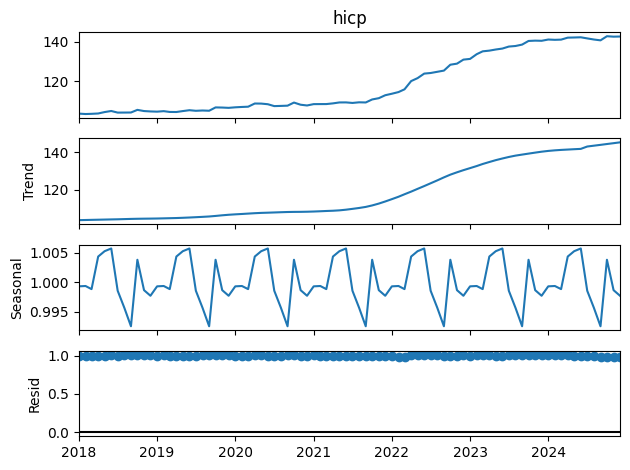

In [14]:
# Filtrar la serie
CP011 = df_es[df_es["coicop"] == "CP011"].copy()

# Descomposición
result_mul = seasonal_decompose(CP011['hicp'], model='multiplicative', extrapolate_trend='freq')

# Visualizar
result_mul.plot()
plt.tight_layout()
plt.show()

In [15]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstr_CP011 = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis = 1)
df_reconstr_CP011.columns = ['seasonal', 'trend', 'resid', 'actual_values']
df_reconstr_CP011.tail()

,seasonal,trend,resid,actual_values
date,,,,
2024-08-01,0.995693,143.353841,0.988676,141.12
2024-09-01,0.992554,143.796629,0.985805,140.70
2024-10-01,1.003826,144.239418,0.986109,142.78
2024-11-01,0.998675,144.682206,0.986639,142.56
2024-12-01,0.997727,145.124995,0.985047,142.63


## CP0111
(Pan y cereales)

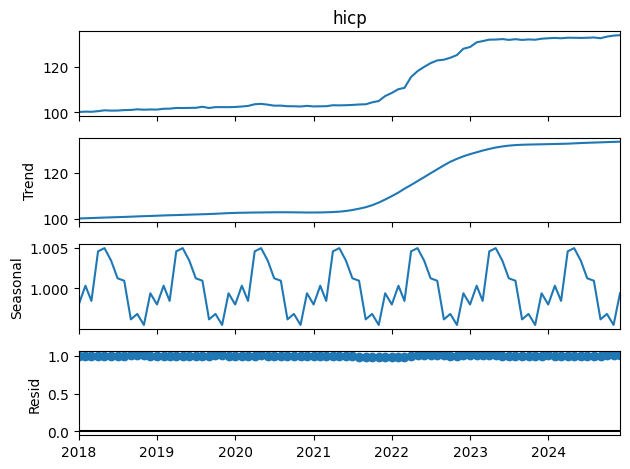

In [16]:
# Filtrar la serie
CP0111 = df_es[df_es["coicop"] == "CP0111"].copy()

# Descomposición
result_mul = seasonal_decompose(CP0111['hicp'], model='multiplicative', extrapolate_trend='freq')

# Visualizar
result_mul.plot()
plt.tight_layout()
plt.show()

In [17]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstr_CP0111 = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis = 1)
df_reconstr_CP0111.columns = ['seasonal', 'trend', 'resid', 'actual_values']
df_reconstr_CP0111.tail()

,seasonal,trend,resid,actual_values
date,,,,
2024-08-01,1.000952,133.185923,0.997805,133.02
2024-09-01,0.996208,133.285877,0.999168,132.67
2024-10-01,0.996875,133.385830,1.003166,133.39
2024-11-01,0.995522,133.485783,1.007088,133.83
2024-12-01,0.999412,133.585737,1.003916,134.03


- Aquí en Seasonal se ve que hay más picos de subidas y bajadas lo que indica que hay mayor fluctuación de precios a lo largo del año.

## CP01112
(Cereales para desayuno)

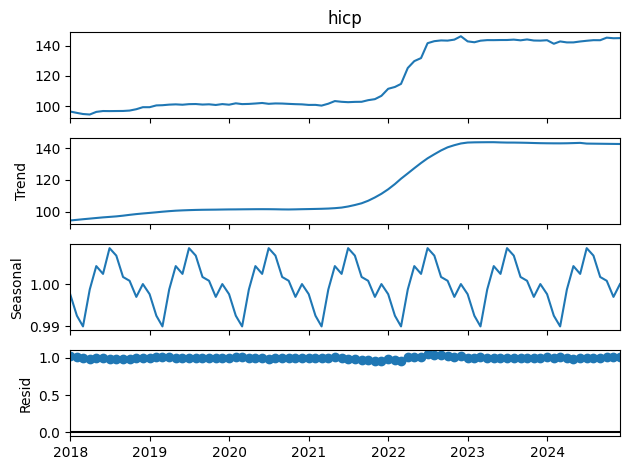

In [18]:
# Filtrar la serie
CP01112 = df_es[df_es["coicop"] == "CP01112"].copy()

# Descomposición
result_mul = seasonal_decompose(CP01112['hicp'], model='multiplicative', extrapolate_trend='freq')

# Visualizar
result_mul.plot()
plt.tight_layout()
plt.show()

In [19]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstr_CP0112 = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis = 1)
df_reconstr_CP0112.columns = ['seasonal', 'trend', 'resid', 'actual_values']
df_reconstr_CP0112.tail()

,seasonal,trend,resid,actual_values
date,,,,
2024-08-01,1.006725,142.728935,0.999104,143.56
2024-09-01,1.001665,142.676935,1.004307,143.53
2024-10-01,1.000767,142.624934,1.017414,145.22
2024-11-01,0.996954,142.572934,1.019005,144.84
2024-12-01,0.999991,142.520934,1.016842,144.92


- Aquí se ve que es más ruidosa, puede deberse a problemas por guerras, coste enregéticos o disrupciones en las cadenas de suministros.

## CP02
(Bebidas alcohólicas, tabaco y narcóticos)

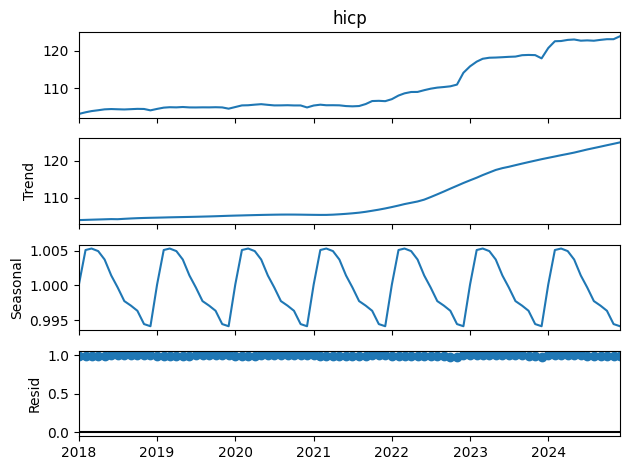

In [20]:
# Filtrar la serie
CP02 = df_es[df_es["coicop"] == "CP02"].copy()

# Descomposición
result_mul = seasonal_decompose(CP02['hicp'], model='multiplicative', extrapolate_trend='freq')

# Visualizar
result_mul.plot()
plt.tight_layout()
plt.show()

In [21]:
# Extract the Components ----
# Actual Values = Product of (Seasonal * Trend * Resid)
df_reconstr_CP02 = pd.concat([result_mul.seasonal, result_mul.trend, result_mul.resid, result_mul.observed], axis = 1)
df_reconstr_CP02.columns = ['seasonal', 'trend', 'resid', 'actual_values']
df_reconstr_CP02.tail()

,seasonal,trend,resid,actual_values
date,,,,
2024-08-01,0.997740,123.370775,0.997303,122.76
2024-09-01,0.997084,123.754460,0.996730,122.99
2024-10-01,0.996348,124.138146,0.995838,123.17
2024-11-01,0.994435,124.521832,0.994679,123.17
2024-12-01,0.994125,124.905518,0.998376,123.97


## Root test Stationary

In [22]:
from statsmodels.tsa.stattools import adfuller, kpss

test_stationary = adfuller(CP00["hicp"].values)
test_stationary[1]

0.8197112147019343

Con ese resultado se ve que es estacionaria. Para poder aplicar ARIMA tengo que transformar esto.

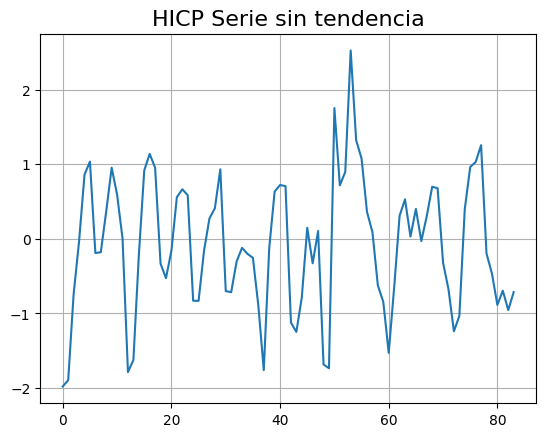

In [23]:
# Using statmodels: Subtracting the Trend Component.
from statsmodels.tsa.seasonal import seasonal_decompose 


#Filtrar:
CP00= df_es[df_es["coicop"] == "CP00"].copy()
#Desc. aditiva
result_add = seasonal_decompose(CP00["hicp"], model='aditive', extrapolate_trend='freq')#Hace una descomposición aditiva de la serie 'value'. El resultado (result_add) contiene:

#Restar la tendencia
detrended = CP00["hicp"].values - result_add.trend.values #trendResta la tendencia a los datos originales. El resultado es una serie detrendida, es decir, sin tendencia.

plt.plot(detrended)
plt.title("HICP Serie sin tendencia", fontsize=16);
plt.grid(True)
plt.show()


In [24]:
CP00[["hicp"]].head()

,hicp
date,
2018-01-01,101.22
2018-02-01,101.37
2018-03-01,102.59
2018-04-01,103.36
2018-05-01,104.32


In [25]:
CP00['hicp'].diff() #genera la columna de restar con el que lo precede(notas flor)

date
2018-01-01     NaN
2018-02-01    0.15
2018-03-01    1.22
2018-04-01    0.77
2018-05-01    0.96
              ... 
2024-08-01    0.03
2024-09-01   -0.12
2024-10-01    0.49
2024-11-01    0.04
2024-12-01    0.54
Name: hicp, Length: 84, dtype: float64

0.5398766673918517


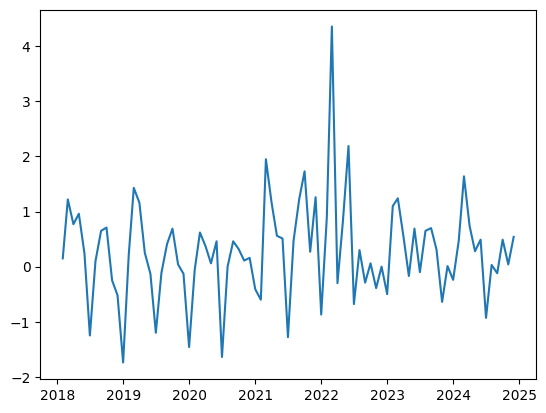

In [26]:
# Using statmodels #Aqui se saca la anterior pero restando la diferencia con la anterior y vemos que no queda bien
from statsmodels.tsa.seasonal import seasonal_decompose
CP00 =  df_es[df_es["coicop"] == "CP00"].copy()

plt.plot(CP00["hicp"].diff()) # .dropna() es necesario porque .diff() genera un NaN al principio.
print(adfuller(CP00["hicp"].diff().dropna().values)[1])#adfuller(...)[1] devuelve el p-valor del test:
#plt.title('HICP diferenciado (sin tendencia)', fontsize=16);

Quito la tendencia de la serie hicp mediante .diff().

Evalúo la estacionariedad con el test adFuller, el test da 0.0 siendo menor que 0.05 por lo que se rechaza la hipot. nula

- p-valor < 0.05, se rechaza la hipótesis nula, indicando que la serie es estacionaria.

- p-valor ≥ 0.05, no se puede rechazar la hipótesis nula, lo que sugiere que la serie no es estacionaria

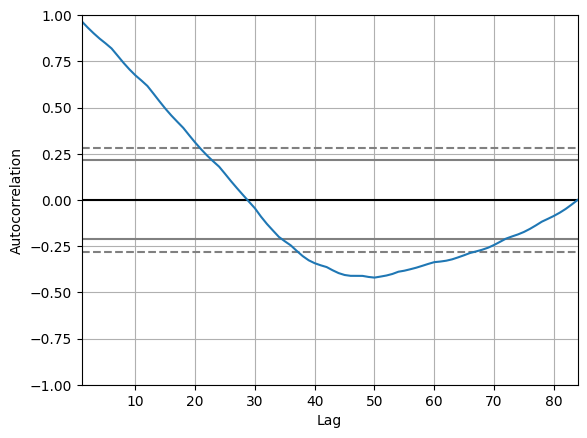

In [27]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(CP00["hicp"]);

- Valores altos de autocorrelación. Fuerte relación con valores recientes, esto creo que es porque tiene patrones muy repetitivos.
- Disminución suave y oscilante de la autocorrelación
- La serie no es estacionaria. Si fuese estacionaria, la autocorrelación caería rápidamente a cero.

## ARIMA ¡¡REVISAR ESTO PORQUE NO ENTIENDO NADAAAA!!

In [28]:
from statsmodels.tsa.arima.model import ARIMA

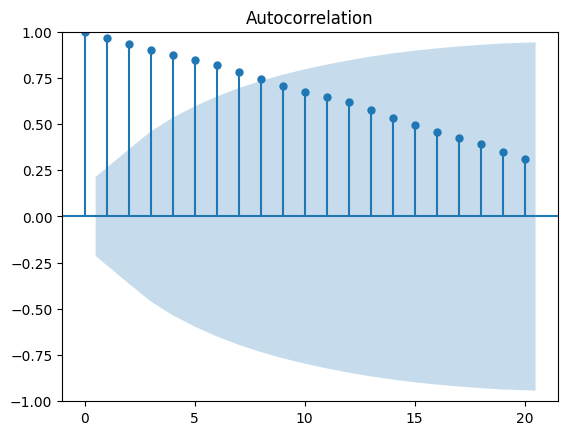

In [29]:
plot_acf(CP00['hicp']);

Del 1 al 10 hay fuerte correlación. Esto demuestra que hay fuerte dependencia temporal. Los valores actuales están relacionados con los anteriores

(x= lags, es decir cuántos pasos atrás estamos mirando
y= de -1 a 1. Cercanos a 1 indican fuerte correlación con ese lag, cerca de 0 poca o ninguna relación, si fuesen negativos sería corr inversa
lags= son las barras
franja azul= intervalo de confianza. Si una barra sale fuera de esa franja es estadísticamente significativa)

In [30]:
# Divide la serie en entrenamiento y prueba (80% - 20%)
split_index = int(len(CP00) * 0.8)
train = CP00["hicp"].iloc[:split_index]
test = CP00["hicp"].iloc[split_index:]


In [31]:
train

date
2018-01-01    101.22
2018-02-01    101.37
2018-03-01    102.59
2018-04-01    103.36
2018-05-01    104.32
               ...  
2023-03-01    119.06
2023-04-01    119.61
2023-05-01    119.44
2023-06-01    120.13
2023-07-01    120.03
Name: hicp, Length: 67, dtype: float64

In [32]:
test

date
2023-08-01    120.68
2023-09-01    121.38
2023-10-01    121.69
2023-11-01    121.05
2023-12-01    121.06
2024-01-01    120.82
2024-02-01    121.29
2024-03-01    122.93
2024-04-01    123.67
2024-05-01    123.95
2024-06-01    124.44
2024-07-01    123.51
2024-08-01    123.54
2024-09-01    123.42
2024-10-01    123.91
2024-11-01    123.95
2024-12-01    124.49
Name: hicp, dtype: float64

In [33]:
model_ar= ARIMA(endog=train, order=(1,0,0))
model_fit= model_ar.fit()


In [34]:
from sklearn.metrics import mean_absolute_error
predictions = model_fit.forecast(steps=len(test))
rmse_arima= np.sqrt(mean_squared_error(test, predictions))
mae_arima= mean_squared_error(test, predictions)
print("rmse:", rmse_arima) #saca el rmse
print("MAE:", mae_arima) #saca el rmse

rmse: 3.633426148430698
MAE: 13.201785576099937


In [35]:
predictions

2023-08-01    119.963159
2023-09-01    119.896771
2023-10-01    119.830832
2023-11-01    119.765341
2023-12-01    119.700294
2024-01-01    119.635688
2024-02-01    119.571520
2024-03-01    119.507787
2024-04-01    119.444486
2024-05-01    119.381614
2024-06-01    119.319168
2024-07-01    119.257146
2024-08-01    119.195544
2024-09-01    119.134360
2024-10-01    119.073590
2024-11-01    119.013233
2024-12-01    118.953285
Freq: MS, Name: predicted_mean, dtype: float64

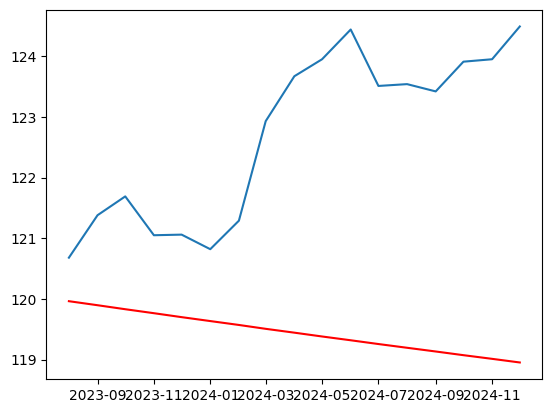

In [36]:
plt.plot(test)
plt.plot(predictions,color='red'); 

## AUTOARIMA

In [37]:

# auto_arima encuentra el mejor ARIMA(p,d,q)
stepwise_model = auto_arima(train,
                            start_p=1, start_q=1,
                            max_p=15, max_q=15,
                            d=None,          # auto-detecta d
                            seasonal=False,  # si no tienes estacionalidad
                            trace=True,      # muestra progreso
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(stepwise_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=186.563, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=185.144, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=186.468, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=186.195, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=188.781, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.113 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   67
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -90.572
Date:                Thu, 15 May 2025   AIC                            185.144
Time:                        11:54:02   BIC                            189.523
Sample:                    01-01-2018   HQIC                           186.874
                         - 07-01-2023                                         
Co

In [38]:
print("NaNs en test:", test.isna().sum())


NaNs en test: 0


In [39]:

n_test = len(test)
forecast = stepwise_model.predict(n_periods=n_test)
forecast = pd.Series(forecast, index=test.index)

# Evaluar
from sklearn.metrics import mean_squared_error
rmse_autoarima = np.sqrt(mean_squared_error(test, forecast))
mae_autoarima= mean_absolute_error(test, forecast)
print("RMSE con auto_arima:", rmse_autoarima)
print("MAE con auto_arima:", mae_autoarima)

RMSE con auto_arima: 0.7017927865245772
MAE con auto_arima: 0.6138224795312811


El modelo se equivoca 0.7 unidades??

In [40]:
print("NaNs en test:", test.isna().sum())
print("NaNs en forecast:", forecast.isna().sum())

NaNs en test: 0
NaNs en forecast: 0


In [41]:
print(stepwise_model)

 ARIMA(0,1,0)(0,0,0)[0] intercept


In [42]:
print(stepwise_model.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   67
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -90.572
Date:                Thu, 15 May 2025   AIC                            185.144
Time:                        11:54:02   BIC                            189.523
Sample:                    01-01-2018   HQIC                           186.874
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2850      0.127      2.239      0.025       0.036       0.534
sigma2         0.9109      0.101      8.987      0.000       0.712       1.110
Ljung-Box (L1) (Q):                   0.71   Jarque-

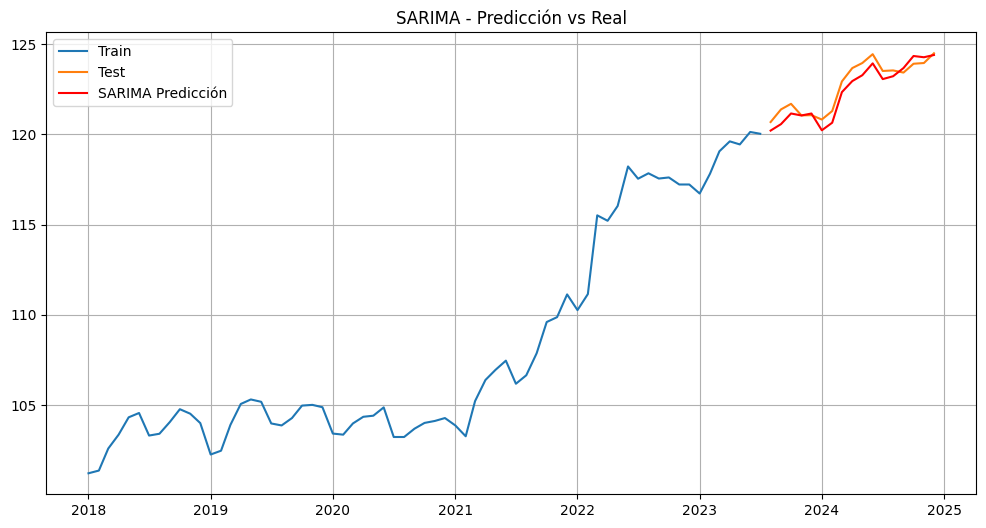

RMSE SARIMAx: 0.497644629108255
MAE SARIMAx: 0.4430588743811922


In [43]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(train, order=(0,1,0), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit()

sarima_pred = sarima_fit.forecast(steps=len(test))
sarima_pred.index = test.index

plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, sarima_pred, label='SARIMA Predicción', color='red')
plt.legend()
plt.grid(True)
plt.title("SARIMA - Predicción vs Real")
plt.show()

rmse_sarimax = np.sqrt(mean_squared_error(test, sarima_pred))
mae_sarimax = mean_absolute_error(test, sarima_pred)
print("RMSE SARIMAx:", rmse_sarimax)
print("MAE SARIMAx:", mae_sarimax)


AÑADO MÁS COICOPS:

In [44]:
df_exog = df_pivot[["CP00","CP01", "CP0111", "CP01112"]] 


In [45]:
#DIVIDO TRAIN Y TEST
exog_train = df_exog.iloc[:split_index]
exog_test = df_exog.iloc[split_index:]

In [46]:
print(exog_train.isna().sum())

coicop
CP00       0
CP01       0
CP0111     0
CP01112    0
dtype: int64


In [47]:
model = SARIMAX(train, exog=exog_train, order=(1,1,0), seasonal_order=(1,1,1,12))
model_fit = model.fit()

In [48]:
pred = model_fit.forecast(steps=len(test), exog=exog_test)

In [49]:

sarima_pred = model_fit.forecast(steps=len(test), exog=exog_test)
rmse_sarimaxii = np.sqrt(mean_squared_error(test, sarima_pred))
mae_sarimaxii = mean_absolute_error(test, sarima_pred)
print("RMSE:", rmse_sarimaxii)
print("MAE:", mae_sarimaxii)

RMSE: 1.0339915591956113e-14
MAE: 7.523393672754002e-15


## SELECCIONAR COICOPS COMO VARIABLES OBJETIVOS EN VEZ DE EXOGENAS:

In [50]:
from statsmodels.tsa.api import VAR
#USAR MODELOS MULTIVARIANTES:

model= VAR(df_exog)
model_fitted= model.fit(maxlags=15, ic="aic")
forecast= model_fitted.forecast(df_exog.values[-model_fitted.k_ar:], steps=6)

In [51]:
# Convertir el forecast en DataFrame con los nombres originales de las columnas
forecast_df = pd.DataFrame(forecast, columns=df_exog.columns)

# Crear el índice de fechas futuras
last_date = df_exog.index[-1]
future_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(), periods=6, freq="MS")
forecast_df.index = future_index

# Mostrar la tabla final con fechas y valores predichos
print(forecast_df)

coicop            CP00        CP01      CP0111     CP01112
2025-01-01  125.844123  143.889475  134.822113  145.881185
2025-02-01  125.211516  143.681061  136.218934  150.413939
2025-03-01  124.855413  144.947146  137.944098  153.794424
2025-04-01  125.649972  146.301960  138.666885  155.001648
2025-05-01  124.632429  147.125091  139.756265  160.326324
2025-06-01  124.246484  146.188460  138.900375  159.169678


## XGBoost


Entrenando modelo para CP00
CP00 - RMSE: 2.5821 | MAE: 2.2503


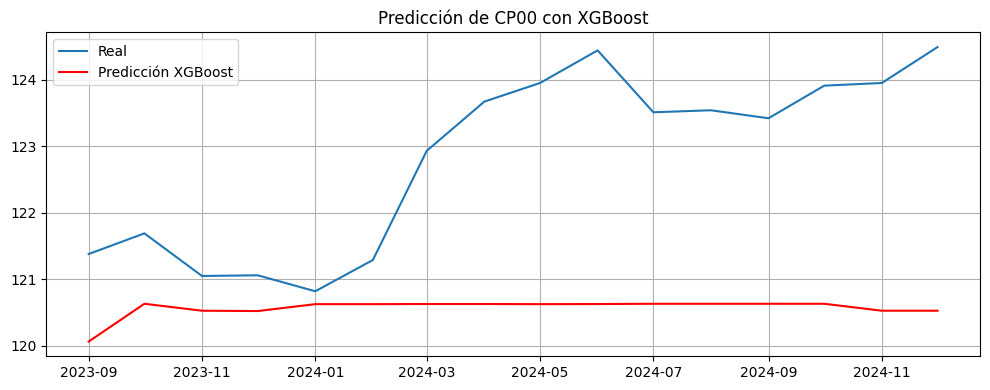


Entrenando modelo para CP01
CP01 - RMSE: 3.7880 | MAE: 3.6193


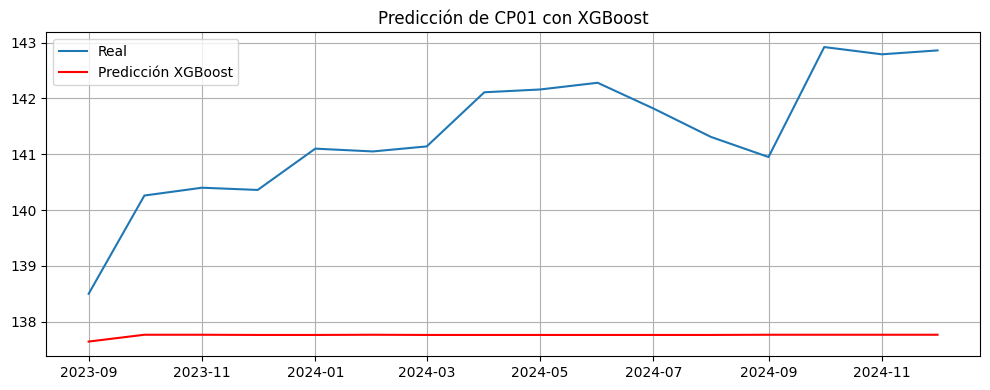


Entrenando modelo para CP0111
CP0111 - RMSE: 0.8829 | MAE: 0.7257


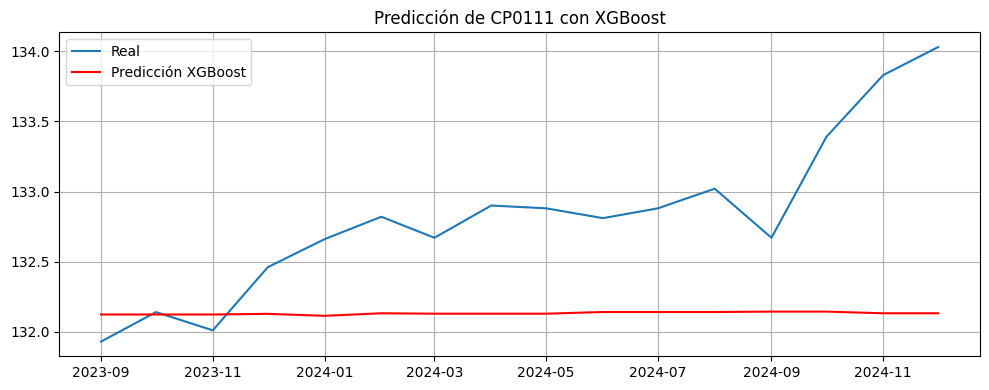


Entrenando modelo para CP01112
CP01112 - RMSE: 1.0814 | MAE: 0.8462


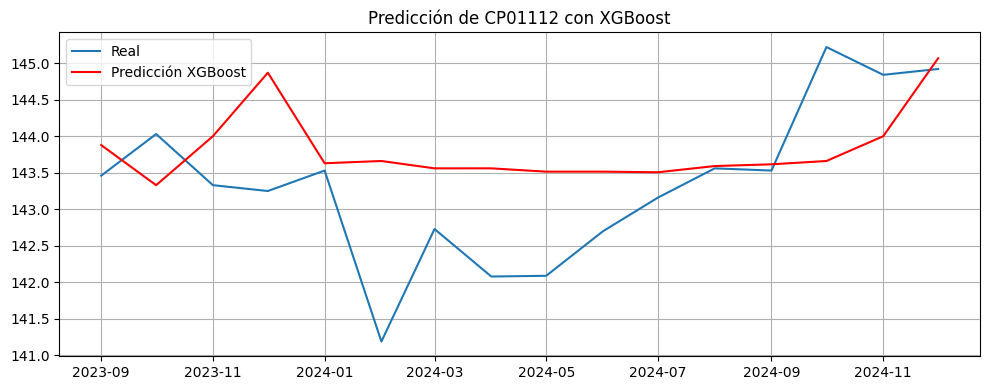

In [66]:
import xgboost as xgb


# Series a predecir
targets = ["CP00", "CP01", "CP0111", "CP01112"]

# Crear base con lags
df_model = df_pivot[targets].copy()
n_lags = 4

# Crear lags para cada serie
for col in targets:
    for lag in range(1, n_lags + 1):
        df_model[f"lag_{col}_{lag}"] = df_model[col].shift(lag)

# Variables temporales
df_model["month"] = df_model.index.month
df_model["year"] = df_model.index.year

# Eliminar NaNs
df_model.dropna(inplace=True)

# Guardar métricas
resultados = {}

for target in targets:
    print(f"\nEntrenando modelo para {target}")

    # Definir variables
    y = df_model[target]
    X = df_model.drop(columns=targets)  # eliminamos todas las originales, dejamos lags y features

    # Train/test split temporal (80/20)
    split = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split], X.iloc[split:]
    y_train, y_test = y.iloc[:split], y.iloc[split:]

    # Entrenar XGBoost
    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
    model.fit(X_train, y_train)

    # Predecir
    y_pred = model.predict(X_test)

    # Calcular métricas
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    resultados[target] = {"RMSE": rmse, "MAE": mae}

    print(f"{target} - RMSE: {rmse:.4f} | MAE: {mae:.4f}")

    # Gráfico
    plt.figure(figsize=(10, 4))
    plt.plot(y_test.index, y_test, label="Real")
    plt.plot(y_test.index, y_pred, label="Predicción XGBoost", color="red")
    plt.title(f"Predicción de {target} con XGBoost")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

In [65]:
# Mostrar métricas finales
df_resultados = pd.DataFrame(resultados).T
print("\nResumen de métricas:")
display(df_resultados)


Resumen de métricas:


,RMSE,MAE
CP00,2.582142,2.250286
CP01,3.788031,3.619266
CP0111,0.882894,0.725723
CP01112,1.081441,0.846152


## MODELOS:

In [67]:

data = {
    'Modelo': ['ARIMA', 'Auto ARIMA', 'SARIMAX', 'XGBoost'],
    'RMSE': [rmse_arima, rmse_autoarima, rmse_sarimax, rmse_XGBoost],
    'MAE': [mae_arima, mae_autoarima, mae_sarimax, mae_XGBoost]  
    
}

df_modelos= pd.DataFrame(data)

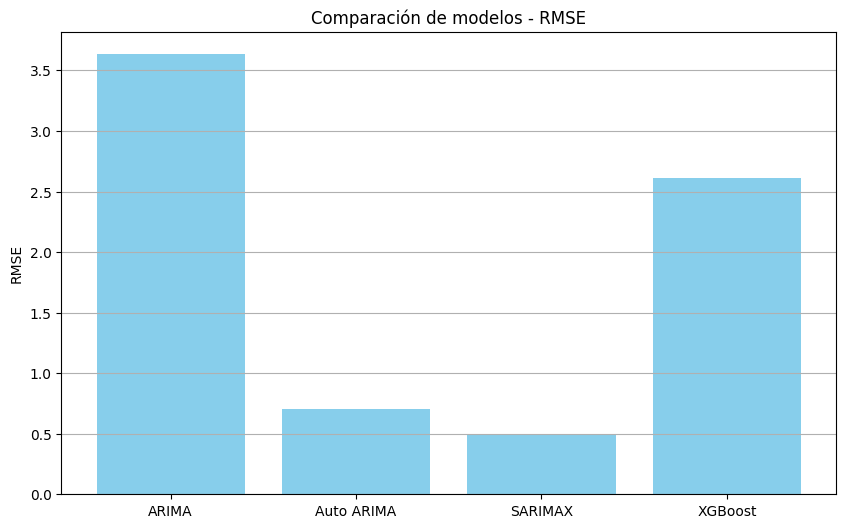

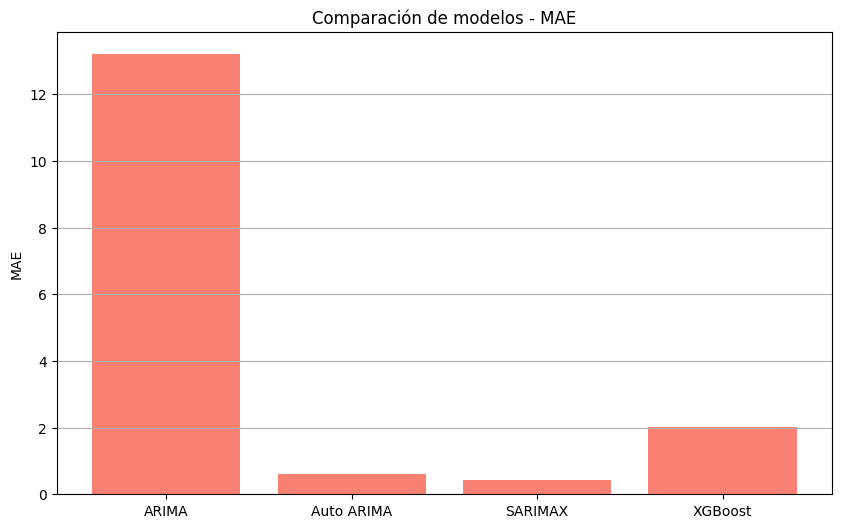

In [68]:
# Gráfico de barras de RMSE
plt.figure(figsize=(10, 6))
plt.bar(df_modelos['Modelo'], df_modelos['RMSE'], color='skyblue')
plt.title('Comparación de modelos - RMSE')
plt.ylabel('RMSE')
plt.grid(axis='y')
plt.show()

# Gráfico de barras de MAE 
df_mae = df_modelos.dropna(subset=['MAE'])

plt.figure(figsize=(10, 6))
plt.bar(df_mae['Modelo'], df_mae['MAE'], color='salmon')
plt.title('Comparación de modelos - MAE')
plt.ylabel('MAE')
plt.grid(axis='y')
plt.show()